In [0]:
import keras
import re
import gc
import os
import nltk
import string
import gensim
from keras.engine.saving import model_from_json
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.models import Sequential ,Model
from keras.layers import Flatten , BatchNormalization,LSTM, GRU ,Conv1D ,MaxPooling1D,Dense
from keras.layers import GlobalMaxPooling1D ,TimeDistributed, Masking
from keras.layers import Dropout,Activation
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import MaxPooling1D,Conv1D
from keras.layers.core import Activation, Dropout, Dense, RepeatVector
from keras.preprocessing.text import one_hot
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Embedding,Input,GlobalAveragePooling1D,Bidirectional
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import pandas as pd
from numpy import array
from textblob import TextBlob
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA, LatentDirichletAllocation
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Read the data
df_train = pd.read_csv('/content/drive/My Drive/Third Semester/Machine Learning /MLProject/December 22/newtrain.csv')
df_dev= pd.read_csv('/content/drive/My Drive/Third Semester/Machine Learning /MLProject/December 22/newdev.csv')

In [19]:
# Dataset is now stored in a Pandas Dataframe
df_train.head()
print(df_train['train-new'].head(20))

0       franc hunt citizen join twin without trial iraq
1     pentagon claim 2000 increas russian troll bowl...
2     iceland pm call snap vote pedophil furor crash...
3               appar first iran israel slap militarili
4                told week ago flynn misl school presid
5               22 sound made speech congress one chart
6                  doj alert system flag laughter polic
7     someon grew among fundamentalist moron surpris...
8               canadian may pay tax american get looni
9                   dutch minist resign drug baron blow
10    dozen dead possibl ga bloat syria regim deni a...
11                                   made pilat le safe
12               second nomine class secretari withdraw
13                                        gop rememb 80
14    mississippi law endors anti lgbt bia attorney ...
15                          chibok salami reunit famili
16    bill aim marri christian minor group pakistan ...
17                           pull rental car jun

In [0]:
# apply tokenization and create sequence matrix on training dataset to make all text the same length
x_train = df_train['train-new']  # to store data as string
x_dev = df_dev['dev_new'] # to store dev data as string
#max_words = 300  # max number of word for Glove
max_words = 3574 # for W2V
#max_words = 17000  # max number of word for fasttext
max_len = 75  # max number of word in each row
def  tokenizersplit(str):
    return str.split();

In [21]:
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_train)  # The Tokenizer stores everything in the "word_index" during "fit_on_texts".
sequences = tok.texts_to_sequences(x_train)  # Then, when calling the "texts_to_sequences method", only the top num_words are considered.
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len, dtype='int32', padding='post', truncating='post', value=0.0)  # Pads sequences to the same length.
print(sequences_matrix)
print('Pad sequence of dev data.....')

[[ 406  577 1924 ...    0    0    0]
 [ 803   66 3358 ...    0    0    0]
 [3359  465   11 ...    0    0    0]
 ...
 [2244  581 1928 ...    0    0    0]
 [  94  577   68 ...    0    0    0]
 [ 231   52  371 ...    0    0    0]]
Pad sequence of dev data.....


In [22]:
# For dev dataset
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(x_dev)  # The Tokenizer stores everything in the "word_index" during "fit_on_texts".
sequences_dev = tok.texts_to_sequences(x_dev)  # Then, when calling the "texts_to_sequences method", only the top num_words are considered.
sequences_matrix_dev = sequence.pad_sequences(sequences_dev, maxlen=max_len, dtype='int32', padding='post', truncating='post', value=0.0)  # Pads sequences to the same length.
print(sequences_matrix_dev)

[[ 548  414 1218 ...    0    0    0]
 [ 103  892  208 ...    0    0    0]
 [1223  185  449 ...    0    0    0]
 ...
 [   3  102  510 ...    0    0    0]
 [2243 2244  653 ...    0    0    0]
 [ 300 1562    0 ...    0    0    0]]


In [0]:
#############################################################################################
# Read the embedding file as glove type
"""print('loading word embeddings (Glove)...')
max_features = 300
EMBEDDING_FILE = "glove.840B.300d.txt"

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8"))

all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tok.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix_glove = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix_glove[i] = embedding_vector

del embeddings_index;
gc.collect()"""
#end of glove
##############################################################################################
##############################################################################################
# Word2Vec (GoogleNews) word embedding
print('loading word embeddings (W2V)...')
import gensim.models.keyedvectors as word2vec

def loadEmbeddingMatrix(typeToLoad):
    # load different embedding file from Kaggle depending on which embedding
    # matrix we are going to experiment with
    if (typeToLoad == "word2vec"):
        word2vecDict = word2vec.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
        embed_size = 300;
        embeddings_index = dict()
        for word in word2vecDict.wv.vocab:
            embeddings_index[word] = word2vecDict.word_vec(word)
        print('Loaded %s word vectors.' % len(embeddings_index))

    gc.collect()
    # We get the mean and standard deviation of the embedding weights so that we could maintain the
    # same statistics for the rest of our own random generated weights.
    all_embs = np.stack(list(embeddings_index.values()))
    emb_mean, emb_std = all_embs.mean(), all_embs.std()

    nb_words = len(tok.word_index)
    # We are going to set the embedding size to the pretrained dimension as we are replicating it.
    # the size will be Number of Words in Vocab X Embedding Size
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    gc.collect()

    # With the newly created embedding matrix, we'll fill it up with the words that we have in both
    # our own dictionary and loaded pretrained embedding.
    embeddedCount = 0
    for word, i in tok.word_index.items():
        i -= 1
        # then we see if this word is in glove's dictionary, if yes, get the corresponding weights
        embedding_vector = embeddings_index.get(word)
        # and store inside the embedding matrix that we will train later on.
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            embeddedCount += 1
    print('total embedded:', embeddedCount, 'common words')

    del (embeddings_index)
    gc.collect()
    # finally, return the embedding matrix
    return embedding_matrix
embedding_matrix_w2v = loadEmbeddingMatrix('word2vec')
##############################################################################################
"""# Fast text Word Embedding
print('loading word embeddings (Fasttext)...')
embeddings_dictionary = dict()
fastetxt_file = open('wiki-news-300d-1M.vec', encoding="utf8")
for line in fastetxt_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

fastetxt_file.close()
embedding_matrix_fast = np.zeros((max_words, 300))
for word, index in tok.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix_fast[index] = embedding_vector
# end of fasttext
##############################################################################################"""
"""#Elmo Word Embedding

# end of Elmo
##############################################################################################"""

loading word embeddings (W2V)...


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function



FileNotFoundError: ignored

In [0]:
data_label = df_train['meanGrade']
embedding_size = 300
model = Sequential()

In [0]:
# Embedding layer
model.add(
    Embedding(input_dim=max_words,
              input_length = max_len,
              output_dim=embedding_size,
              weights=[embedding_matrix_w2v],
              trainable=False,
              mask_zero=True))

In [0]:
# Masking layer for pre-trained embeddings
model.add(Masking(mask_value=0.0))

#input layer
#Recurrent layer
#model.add(GRU(64, return_sequences=False, dropout=0.1, recurrent_dropout=0.1, activation='linear'))#GRU
model.add(Bidirectional(GRU(64, kernel_initializer='normal', input_dim = x_train.shape[0], activation='sigmoid')))
#hidden layer
# Fully connected layer
model.add(Dense(25, kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Dense(15, kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())

#model.add(Dense(25, kernel_initializer='normal',activation='relu'))
#model.add(Dropout(0.5))
#model.add(BatchNormalization())


# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model.summary()


C:\Users\AMCT\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.

C:\Users\AMCT\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning:

Update your `GRU` call to the Keras 2 API: `GRU(64, kernel_initializer="normal", activation="sigmoid", input_shape=(None, 965...)`



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 75, 300)           1072200   
_________________________________________________________________
masking_1 (Masking)          (None, 75, 300)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               140160    
_________________________________________________________________
dense_1 (Dense)              (None, 25)                3225      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
dense_2 (Dense)              (None, 15)               

In [0]:
print('Train...')
# Fit the model
earlystop = EarlyStopping(monitor='mean_squared_error', mode='auto', patience=10, verbose=1)
history = model.fit(sequences_matrix, data_label, batch_size=180000, epochs=300,verbose=1, callbacks=[earlystop])

#history = model.fit(X_train, y_train, epochs=300, batch_size=180000, validation_data=(X_valid, y_valid), callbacks=[earlystop])

#Test the model
# serialize model to JSON
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
    #json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model.h5")
#print("Saved model to disk")


Train...
Instructions for updating:
Use tf.cast instead.
Epoch 1/300
9652/9652 [==============================] - 25s 3ms/step - loss: 0.6017 - mean_squared_error: 0.6017
Epoch 2/300
9652/9652 [==============================] - 27s 3ms/step - loss: 0.5921 - mean_squared_error: 0.5921
Epoch 3/300
9652/9652 [==============================] - 25s 3ms/step - loss: 0.5951 - mean_squared_error: 0.5951
Epoch 4/300
9652/9652 [==============================] - 24s 2ms/step - loss: 0.5872 - mean_squared_error: 0.5872
Epoch 5/300
9652/9652 [==============================] - 24s 2ms/step - loss: 0.5810 - mean_squared_error: 0.5810
Epoch 6/300
9652/9652 [==============================] - 22s 2ms/step - loss: 0.5818 - mean_squared_error: 0.5818
Epoch 7/300
9652/9652 [==============================] - 28s 3ms/step - loss: 0.5900 - mean_squared_error: 0.5900
Epoch 8/300
9652/9652 [==============================] - 28s 3ms/step - loss: 0.5772 - mean_squared_error: 0.5772
Epoch 9/300
9652/9652 [========

9652/9652 [==============================] - 25s 3ms/step - loss: 0.4260 - mean_squared_error: 0.4260
Epoch 71/300
9652/9652 [==============================] - 24s 3ms/step - loss: 0.4248 - mean_squared_error: 0.4248
Epoch 72/300
9652/9652 [==============================] - 24s 2ms/step - loss: 0.4234 - mean_squared_error: 0.4234
Epoch 73/300
9652/9652 [==============================] - 25s 3ms/step - loss: 0.4237 - mean_squared_error: 0.4237
Epoch 74/300
9652/9652 [==============================] - 24s 2ms/step - loss: 0.4225 - mean_squared_error: 0.4225
Epoch 75/300
9652/9652 [==============================] - 23s 2ms/step - loss: 0.4208 - mean_squared_error: 0.4208
Epoch 76/300
9652/9652 [==============================] - 24s 3ms/step - loss: 0.4195 - mean_squared_error: 0.4195
Epoch 77/300
9652/9652 [==============================] - 23s 2ms/step - loss: 0.4180 - mean_squared_error: 0.4180
Epoch 78/300
9652/9652 [==============================] - 28s 3ms/step - loss: 0.4180 - mean_

Epoch 141/300
9652/9652 [==============================] - 21s 2ms/step - loss: 0.3700 - mean_squared_error: 0.3700
Epoch 142/300
9652/9652 [==============================] - 22s 2ms/step - loss: 0.3713 - mean_squared_error: 0.3713
Epoch 143/300
9652/9652 [==============================] - 22s 2ms/step - loss: 0.3705 - mean_squared_error: 0.3705
Epoch 144/300
9652/9652 [==============================] - 21s 2ms/step - loss: 0.3705 - mean_squared_error: 0.3705
Epoch 145/300
9652/9652 [==============================] - 22s 2ms/step - loss: 0.3685 - mean_squared_error: 0.3685
Epoch 146/300
9652/9652 [==============================] - 22s 2ms/step - loss: 0.3700 - mean_squared_error: 0.3700
Epoch 147/300
9652/9652 [==============================] - 22s 2ms/step - loss: 0.3698 - mean_squared_error: 0.3698
Epoch 148/300
9652/9652 [==============================] - 22s 2ms/step - loss: 0.3675 - mean_squared_error: 0.3675
Epoch 149/300
9652/9652 [==============================] - 21s 2ms/step 

In [0]:
# later...
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

print("Loaded model from disk")

Loaded model from disk


In [0]:
# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
score = loaded_model.predict(sequences_matrix_dev)
df_dev['pred']= score
header_pre1 = ["id", "pred"]
df_dev.to_csv(r'task-1-output.csv',columns=header_pre1)
print(score)

[[0.2678182 ]
 [0.40861812]
 [0.672675  ]
 ...
 [0.9452318 ]
 [0.4519152 ]
 [0.9141047 ]]


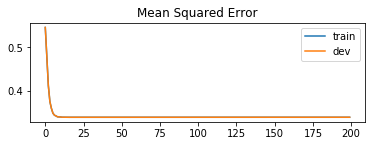

In [0]:
from matplotlib import pyplot
pyplot.subplot(212)
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['mean_squared_error'], label='train')
pyplot.plot(history.history['mean_squared_error'], label='dev')
pyplot.legend()
pyplot.show()
